In [24]:
#Imports

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from tensorflow.keras import layers, callbacks
print(tf.__version__)

2.6.0


In [25]:
# Reproducability
# Setup the random seed so training data is feed in the same each run.
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
# The plotting layout presets.
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')



# Load training and validation sets
# Create a tensorflow datasta (tf.data.Dataset).  Matches the images with the binary label "Car" or "Truck".  All the images are 128x128 and if they need to be resized use nearsest neighbor interpolation.    Shuffle the training set.  Do not shuffle the validation set.  It doesn't matter the order of the validation no need to shuffle. 
ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
# Process the images into pixel arrays so matrix operations can be preformed on them.  
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

# Putting it all together.  Take the training dataset which is sized and labeled.  Convert to pixel array.  Cache in memory for faster runtime.  Autotune sets up the CPU so it's fetching the next image in the list while the current image is in the CNN.  
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 2000 files belonging to 2 classes.
Found 1909 files belonging to 2 classes.


In [26]:
model = keras.Sequential([

    # Preprocessing
    # preprocessing.RandomFlip('horizontal'), # flip left-to-right
    # preprocessing.RandomContrast(0.5), # contrast change by up to 50%

    # First Convolutional Block
    # 32 filter layers, Kernel Size of 5 x 5. Relu activation.  Add zeroes all around so the image doesn't change size, Padding='same'.
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
 
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    
    layers.MaxPool2D(),

    #Fourth Convolutional Block
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
    
    layers.MaxPool2D(),


    #Fourth Convolutional Block
    layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same'),
   
    layers.MaxPool2D(),

    #Fourth Convolutional Block
    layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same'),
    
    layers.MaxPool2D(),

    # Classifier Head.  Fully connected Dense layer with 6 nodes and a relu activation.  Final node for binary decision. 
    layers.Flatten(),\
    # layers.Dense(units=256, activation="relu"),
    # layers.BatchNormalization(),
    # layers.Dropout(0.2),
    # layers.Dense(units=128, activation="relu"),
    # layers.BatchNormalization(),
    # layers.Dropout(0.2),
    # layers.Dense(units=64, activation="relu"),
    # layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.Dense(units=512, activation="relu"),
    # layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.Dense(units=196, activation="relu"),
    # layers.BatchNormalization(),
    # layers.Dense(units=1, activation="sigmoid"),
])


In [27]:
opt = tf.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

model.build()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 256)      

In [28]:


# Fit the Model. 
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=1,
    verbose=1,
)

 3/32 [=>............................] - ETA: 42s - loss: 4.0185 - binary_accuracy: 0.5573

KeyboardInterrupt: 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 256)      

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


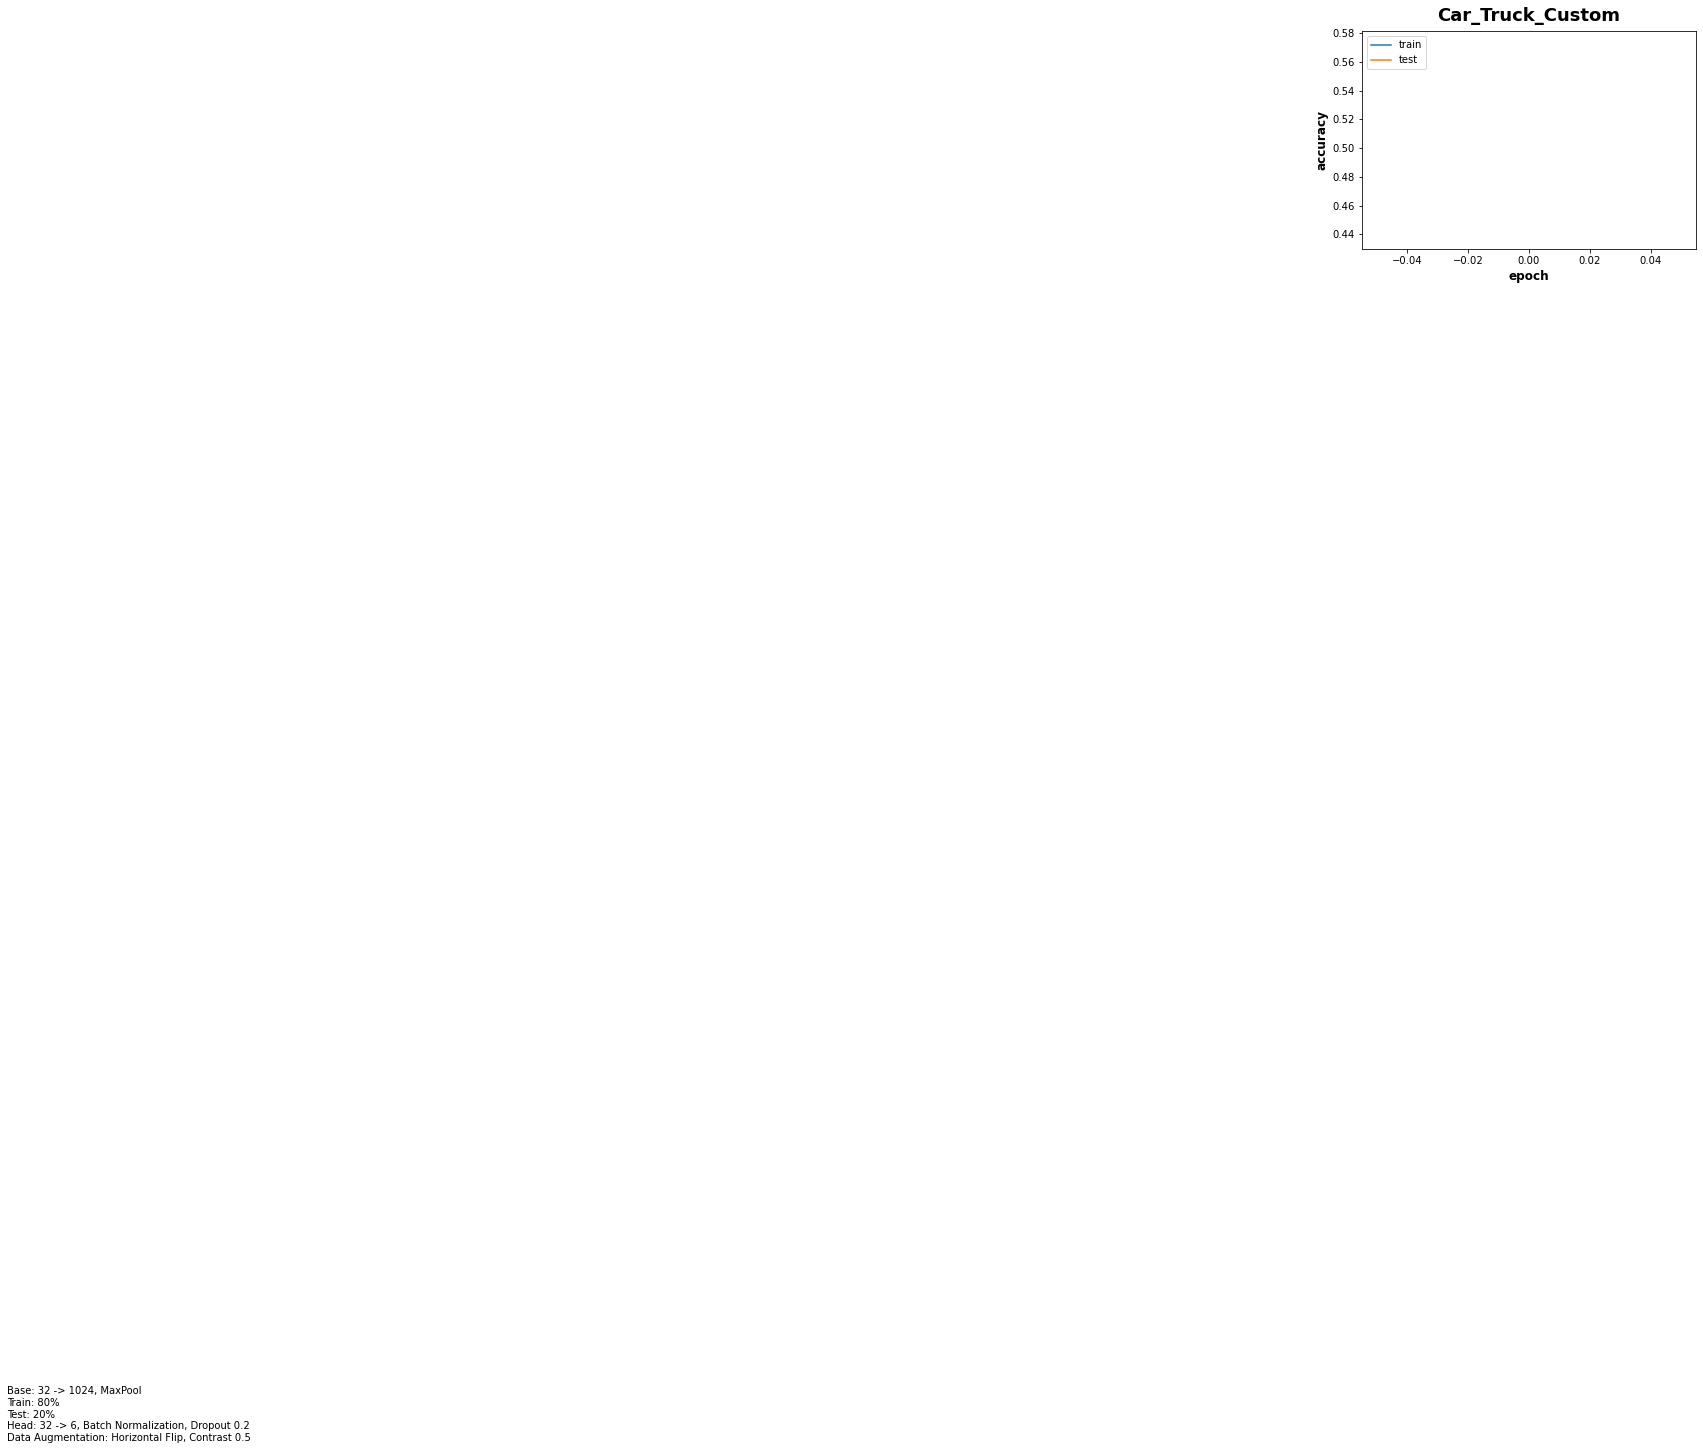

In [ ]:
caption = 'Base: 32 -> 1024, MaxPool' '\n' 'Train: 80%''\n''Test: 20%''\n''Head: 32 -> 6, Batch Normalization, Dropout 0.2' '\n' 'Data Augmentation: Horizontal Flip, Contrast 0.5'

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Car_Truck_Custom')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.text(-.5,-.4, caption)

# Save as PDF
plt.savefig("Car_Truck_Custom_Deeper.pdf", bbox_inches = "tight")
plt.show()

# import pandas as pd

# history_frame = pd.DataFrame(history.history)
# history_frame.loc[:, ['loss', 'val_loss']].plot()
# history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
# print(history_frame.val_binary_accuracy)